# Statistical Testing Templates for CPTAC Data

<b>Standard imports for playing with and plotting data frames.</b>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.stats.multitest
#import altair as alt
#alt.renderers.enable('notebook') #Necessary for Altair to work

In [2]:
import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [3]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

#print(phos)

#Try Looking at all proteins, not just interacting proteins
all_proteins = list(proteomics.columns.values)

## t-test for effects of all mutations combined
<b>Note:</b> You can put any number of proteins in the list and it will compare that gene with the protein levels of all of them

### List of interacting proteins (according to STRING and Uniprot)

In [4]:
#Build the protein list; this may have only a single protein if desired
#protList = ['IRS1', 'IRS2', 'RRAS', 'AKT2', 'NRAS', 'PTEN', 'AKT1', 'MRAS', 'HRAS', 'RPS6KB1', 'PIK3R1', 'PKC', 'MTOR', 'S6K', 'MAPK', 'ERBB3', 'P85A', 'P55G', 'CDK5']
protList = all_proteins
#protList = ['AHNAK','PPP1R12A']

In [7]:
gene = 'PIK3CA'
tested = [];
p_vals = [];
for protein in protList: 
    if protein in proteomics.columns:
        tested.append(protein)
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross[:100]
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] != "Wildtype"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        p_vals.append(ttest[1])

KeyboardInterrupt: 

In [ ]:
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_vals)[0]
pvals = statsmodels.stats.multitest.fdrcorrection(p_vals)[1]
significant_proteins = np.array(tested)[np.array(areSignificant)]
significant_pvals = np.array(pvals)[np.array(areSignificant)]

In [ ]:
print(significant_proteins)
print(significant_pvals)

### Test for phosphorylation levels (mutation in any gene with phosphorylation of any protein)

In [5]:
#List of proteins (will test all phosphorylation sites on these proteins)
phosProtList = protList

In [12]:
sites = phos.columns
p_values = []
site_names = []
gene = 'PIK3CA'

for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
       
        for site in phosphositesdf.columns:
            #just making sure not to do comparison on mutation column
            if (site is not 'Mutation'):
                sitedf = CPTAC.compare_mutations(phos, site, gene)
                sitedf = sitedf.loc[sitedf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
                #print(sitedf[99:140])
                mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
                wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
                #if len(mutateddf) > 20:
                ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
                p_values.append(ttest[1])
                site_names.append(site)



#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])
#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'

print(p_values)
print(site_names)
        


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Seeing significance of P values using bonferroni correction

In [10]:
threshold_pval = .05/len(site_names)
print("threshold_pval: ", threshold_pval)
bonferonni_corrected_pvals = list()
bonferonni_sig_sites = list()
for ind in range(0, len(p_values)):
    if p_values[ind] <= threshold_pval:
        bonferonni_corrected_pvals.append(p_values[ind])
        bonferonni_sig_sites.append(site_names[ind])
        
        
bf_significant_vals = dict(zip(bonferonni_sig_sites, bonferonni_corrected_pvals))

threshold_pval:  5.747787101965744e-06


### Print signifcant p-values

In [11]:
#print("\nSignificant P-values from Bonferroni: ", bonferonni_corrected_pvals)
#print("\nSignificant Sites from Bonferroni: ", bonferonni_sig_sites)
#sortedkeys = sort(bf_significant_vals.keys())
#for key in sortedkeys:
#    print (key, bf_significant_vals[key])
#print("\nSignificant values: ", bf_significant_vals)

for key in sorted(bf_significant_vals):
    #print(%s: %s % (key, bf_significant_vals[key]))
    print(key, bf_significant_vals[key])

print(len(bonferonni_sig_sites))
print(len(bonferonni_corrected_pvals))
print(len(site_names))


#indexMin = bonferonni_corrected_pvals.index(min(bonferonni_corrected_pvals))

#print("Min P-val: ", bonferonni_corrected_pvals[index_min])
#print("Site name at min: ", bonferonni_sig_sites[index_min])

0
0
8699


### Use FDR Correction

In [12]:
pvalues = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[1]         
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[0]

significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]
significant_vals = dict(zip(significant_sites, significant_pvalues))


print("\nSignificant P-vals (FDR): ", significant_pvalues)
print("\nSignificant sites (FDR): ", significant_sites)
print("\nSignificant values (FDR): ", significant_vals)

print(len(significant_sites))


Significant P-vals (FDR):  []

Significant sites (FDR):  []

Significant values (FDR):  {}
0


### Plot phosphorylation levels and gene mutation
<b>Note:</b> There may be fewer data points due to NA values

[Text(0, 0.5, 'Phosphoproteomics'), Text(0.5, 0, 'Somatic Gene Mutation')]

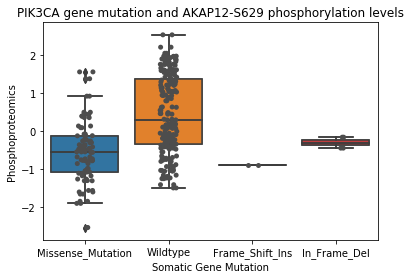

In [13]:
#Specify the gene and the site; you may use a string to specify the site or reference the significant results above

gene = 'PIK3CA'

site="AKAP12-S629"

#Build the dataframe for plotting
genedf = CPTAC.compare_mutations(phos, site, gene)
genedf = genedf.loc[genedf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)

#print(genedf)
#sites = phos.filter(regex=site)
#genedf = genedf.add(sites, fill_value=0)

phos_boxplot = sns.boxplot(data=genedf, x="Mutation" ,y=site)
phos_boxplot.set_title(gene + " gene mutation and " + site + " phosphorylation levels")
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")

print("\n")

phos_boxplot = sns.boxplot(data=genedf, x="Mutation" ,y=site)
phos_boxplot.set_title(gene + " gene mutation and " + site + " phosphorylation levels")
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")